# (Temporary) Notebook that Compares Quant results to the SIMs that Mark created

In [1]:
import multiprocessing as mp
import numpy as np
#import multiprocess as mp  # A fork of multiprocessing that uses dill rather than pickle
import yaml # pyyaml library for reading the parameters.yml file
import os

import matplotlib.pyplot as plt

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

import functions # Some additional notebook-specific functions required (functions.py)

# Useful for connecting to this kernel
%connect_info

{
  "shell_port": 64015,
  "iopub_port": 64016,
  "stdin_port": 64017,
  "control_port": 64019,
  "hb_port": 64018,
  "ip": "127.0.0.1",
  "key": "5cc9b572-41a8d380b68b64f351627ec3",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-62da26bf-33fb-4643-8c5b-7bf5e9338641.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


## Code to make plots

This is taken from `sensitivity_analysis.ipynb`

In [2]:
def plot_summaries(summaries, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )
                
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

## 1. Traditional run Setup params for all runs

Run the model using non-quant data. Note that the model needs to have been at least initialised previously to create the snapshots below

In [3]:
USE_QUANT = "no-quant"  # CHANGE THIS TO USE QUANT ('quant') OR NOT ('no-quant')

PARAMETERS_FILENAME = f"default-{USE_QUANT}.yml"

with open(os.path.join("..","model_parameters", PARAMETERS_FILENAME)) as f:
    parameters = yaml.load(f, Loader=yaml.SafeLoader)
    
sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]  # Parameters for the disease model (r)

# This is a snapshot created earlier
opencl_dir = f"../microsim/opencl/"
snapshot_filepath = os.path.join(opencl_dir, "snapshots", USE_QUANT, "cache.npz")

current_risk_beta = disease_params['current_risk_beta']

# The OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
    primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
    secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
    home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
    work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
)

# Individual hazard multipliers can be passed straight through
individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
    asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
    symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
)

proportion_asymptomatic = disease_params["asymp_rate"]

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    proportion_asymptomatic=proportion_asymptomatic
)

Run the model

In [4]:
iterations = 120
repetitions = 10
num_seed_days = 10
use_gpu=False

# Prepare the function arguments as lists for starmap
l_i = [i for i in range(repetitions)]
l_iterations = [iterations] * repetitions
l_snapshot_filepath = [snapshot_filepath] * repetitions
l_params = [params] * repetitions
l_opencl_dir = [opencl_dir] * repetitions
l_num_seed_days = [num_seed_days] * repetitions
l_use_gpu = [use_gpu] * repetitions
l_store_detailed_counts= [True] * repetitions  # If False then model is much quicker but no age breakdown

#results = functions.run_opencl_model_multiprocess(
#    l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu)

import itertools  # (only while I can't get multiprocessing to work)
try:
    with mp.Pool(processes=int(os.cpu_count())) as pool:
        #results = pool.starmap(
        results = itertools.starmap(
            functions._run_opencl_model, zip(
                l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu, l_store_detailed_counts
        ))
finally:  # Make sure they get closed (shouldn't be necessary)
    pool.close()

summaries_no_quant = [x[0] for x in results]
final_results = [x[1] for x in results] 

Running simulation 1.
Running simulation 2.
Running simulation 3.
Running simulation 4.
Running simulation 5.
Running simulation 6.
Running simulation 7.
Running simulation 8.
Running simulation 9.
Running simulation 10.


### Plot MSOA geodata

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


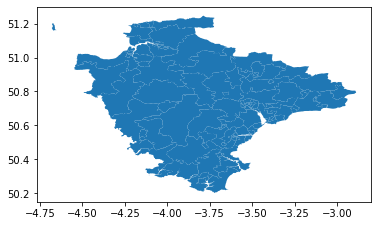

In [7]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [8]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

## 2. Quant run

Run the model using non-quant data. Note that the model needs to have been at least initialised previously to create the snapshots below

In [9]:
USE_QUANT = "quant"  # CHANGE THIS TO USE QUANT ('quant') OR NOT ('no-quant')

PARAMETERS_FILENAME = f"default-{USE_QUANT}.yml"

with open(os.path.join("..","model_parameters", PARAMETERS_FILENAME)) as f:
    parameters = yaml.load(f, Loader=yaml.SafeLoader)
    
sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]  # Parameters for the disease model (r)

# This is a snapshot created earlier
opencl_dir = f"../microsim/opencl/"
snapshot_filepath = os.path.join(opencl_dir, "snapshots", USE_QUANT, "cache.npz")

current_risk_beta = disease_params['current_risk_beta']

# The OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
    primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
    secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
    home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
    work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
)

# Individual hazard multipliers can be passed straight through
individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
    asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
    symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
)

proportion_asymptomatic = disease_params["asymp_rate"]

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    proportion_asymptomatic=proportion_asymptomatic
)

Run the model

In [10]:

# Prepare the function arguments as lists for starmap
l_i = [i for i in range(repetitions)]
l_iterations = [iterations] * repetitions
l_snapshot_filepath = [snapshot_filepath] * repetitions
l_params = [params] * repetitions
l_opencl_dir = [opencl_dir] * repetitions
l_num_seed_days = [num_seed_days] * repetitions
l_use_gpu = [use_gpu] * repetitions
l_store_detailed_counts= [True] * repetitions  # If False then model is much quicker but no age breakdown

#results = functions.run_opencl_model_multiprocess(
#    l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu)

import itertools  # (only while I can't get multiprocessing to work)
try:
    with mp.Pool(processes=int(os.cpu_count())) as pool:
        #results = pool.starmap(
        results = itertools.starmap(
            functions._run_opencl_model, zip(
                l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu, l_store_detailed_counts
        ))
finally:  # Make sure they get closed (shouldn't be necessary)
    pool.close()

summaries_quant = [x[0] for x in results]
final_results = [x[1] for x in results] 

Running simulation 1.
Running simulation 2.
Running simulation 3.
Running simulation 4.
Running simulation 5.
Running simulation 6.
Running simulation 7.
Running simulation 8.
Running simulation 9.
Running simulation 10.


## Compare the Quant / Non-Quant (separate plots)

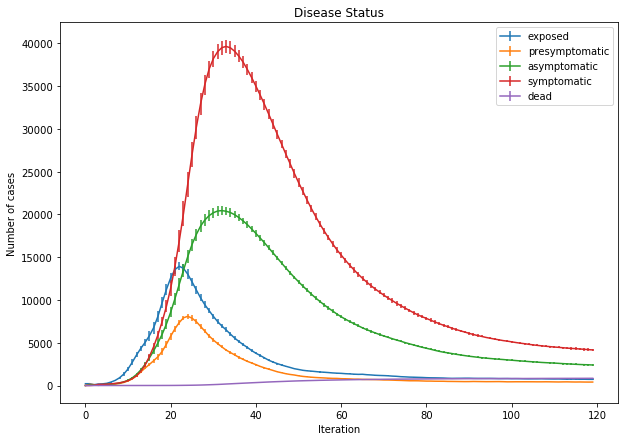

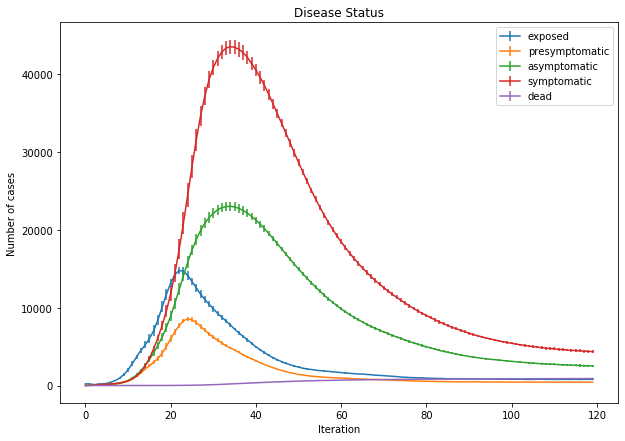

In [11]:
plot_summaries(summaries=summaries_no_quant, plot_type="error_bars")
plot_summaries(summaries=summaries_quant, plot_type="error_bars")

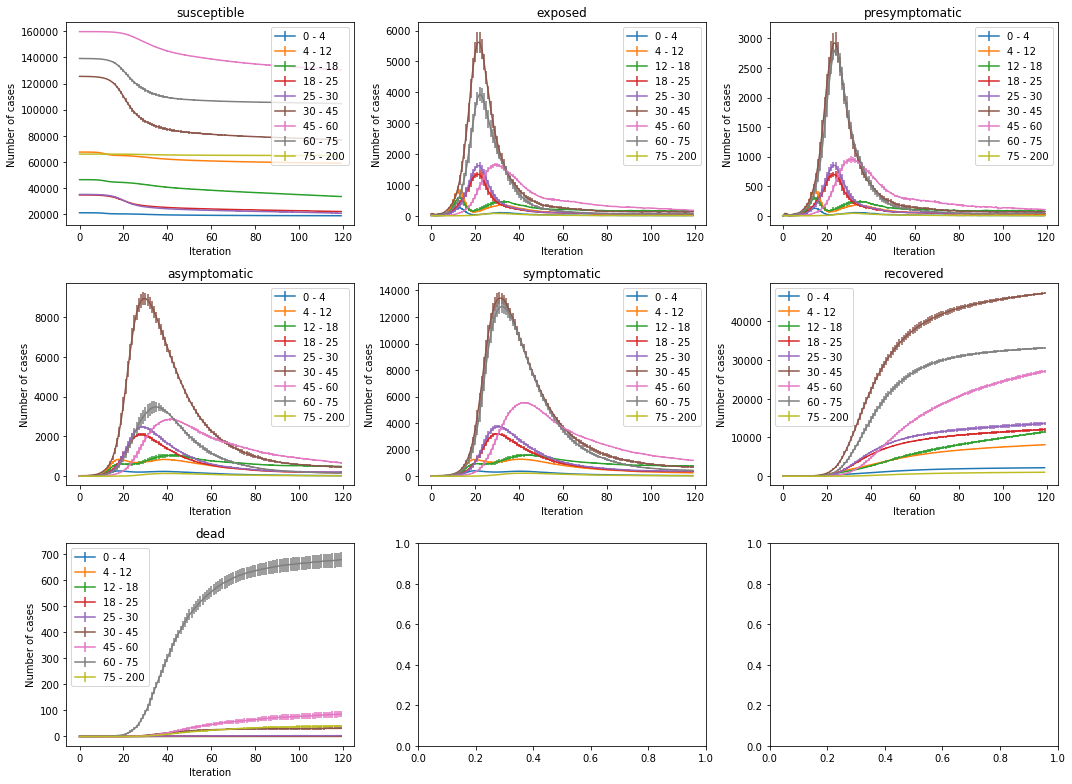

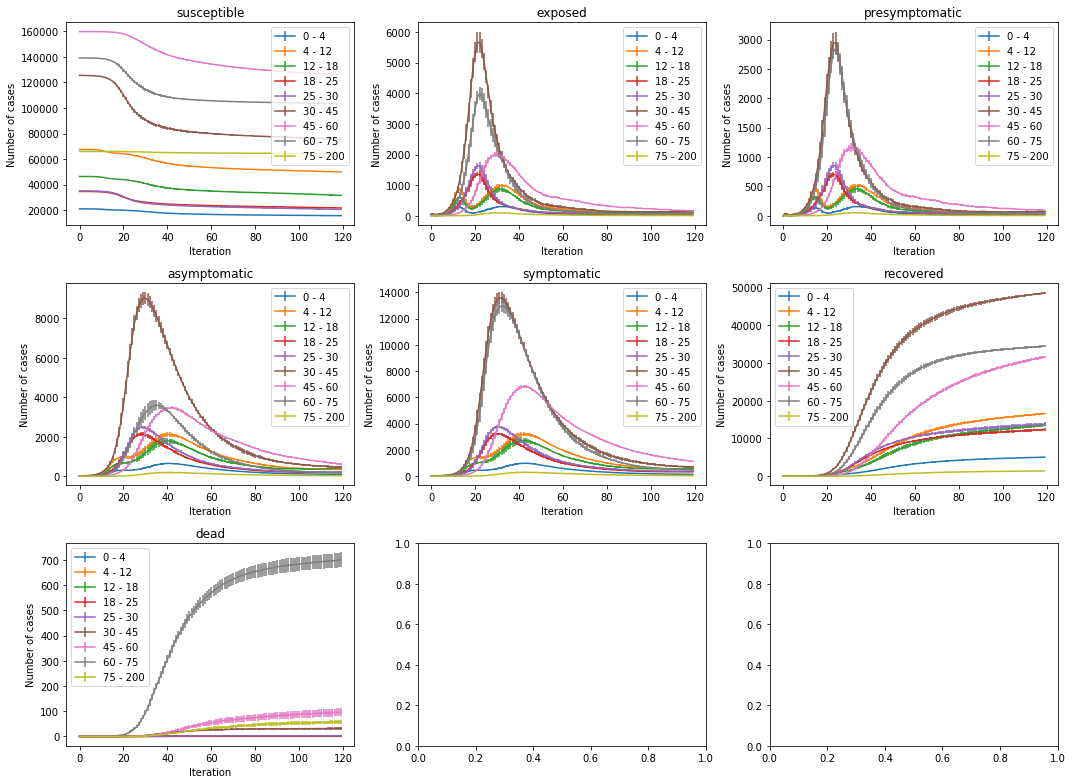

In [12]:
plot_disease_status_by_age(summaries_no_quant)
plot_disease_status_by_age(summaries_quant)

Look at maps

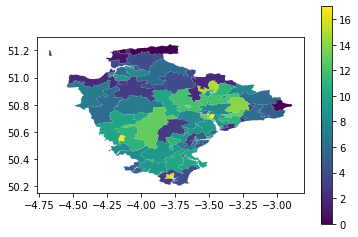

In [13]:
disease_status = "exposed"
plot_msoa_choropleth(devon_msoa_shapes, summaries_no_quant[0], disease_status, 99)

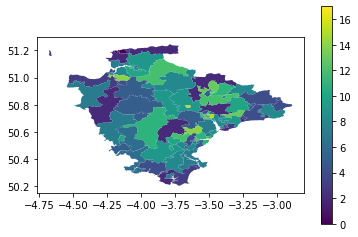

In [14]:
plot_msoa_choropleth(devon_msoa_shapes, summaries_quant[0], disease_status, 99)

## Compare Quant / No_Quant on the same plots

In [15]:
def plot_summaries_diff(summaries1, summaries2):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries1)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries1[rep].total_counts[d] - summaries2[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

def plot_disease_status_by_age_diff(summaries1, summaries2):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries1)
    assert (iters, reps) == _get_iters_and_reps(summaries2)
    x = range(iters)
    age_thresholds = summaries1[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries1[rep].age_counts[str(disease_status)][age_idx] - summaries2[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

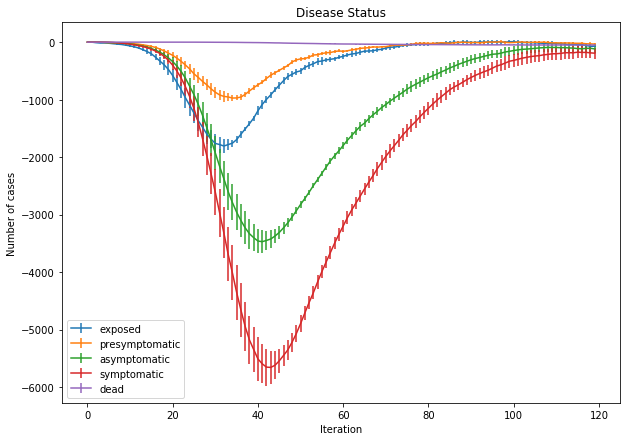

In [16]:
plot_summaries_diff(summaries_no_quant, summaries_quant)

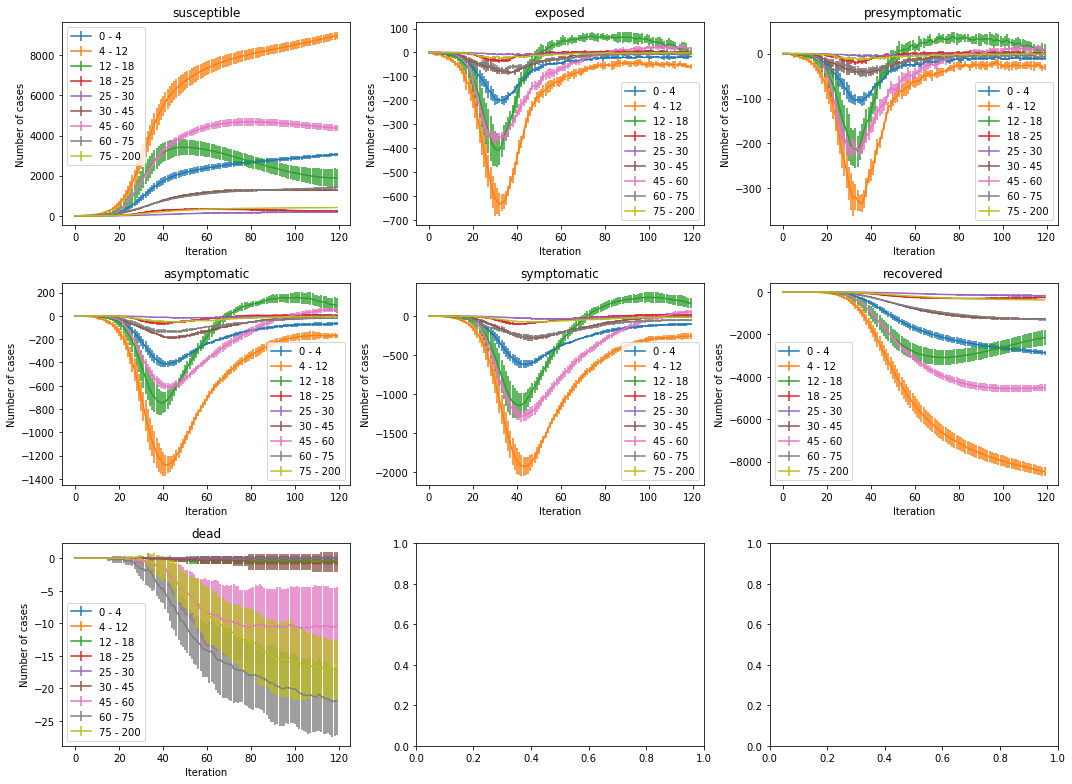

In [17]:
plot_disease_status_by_age_diff(summaries_no_quant, summaries_quant)